In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from medmnist import DermaMNIST
import random
torch.cuda.is_available()

True

Using downloaded and verified file: ./data\dermamnist_64.npz
Using downloaded and verified file: ./data\dermamnist_64.npz
Epoch [1/50], Train Loss: 1.1020, Test Loss: 1.0384, Accuracy: 67.33%
Epoch [2/50], Train Loss: 0.9605, Test Loss: 0.9457, Accuracy: 67.63%
Epoch [3/50], Train Loss: 0.9072, Test Loss: 0.8979, Accuracy: 69.48%
Epoch [4/50], Train Loss: 0.8745, Test Loss: 0.8660, Accuracy: 69.93%
Epoch [5/50], Train Loss: 0.8532, Test Loss: 0.8484, Accuracy: 70.47%
Epoch [6/50], Train Loss: 0.8330, Test Loss: 0.8218, Accuracy: 70.67%
Epoch [7/50], Train Loss: 0.8178, Test Loss: 0.8073, Accuracy: 70.67%
Epoch [8/50], Train Loss: 0.8058, Test Loss: 0.7963, Accuracy: 71.12%
Epoch [9/50], Train Loss: 0.7909, Test Loss: 0.7843, Accuracy: 70.97%
Epoch [10/50], Train Loss: 0.7845, Test Loss: 0.7830, Accuracy: 71.62%
Epoch [11/50], Train Loss: 0.7751, Test Loss: 0.7649, Accuracy: 71.97%
Epoch [12/50], Train Loss: 0.7637, Test Loss: 0.7609, Accuracy: 72.22%
Epoch [13/50], Train Loss: 0.7572, 

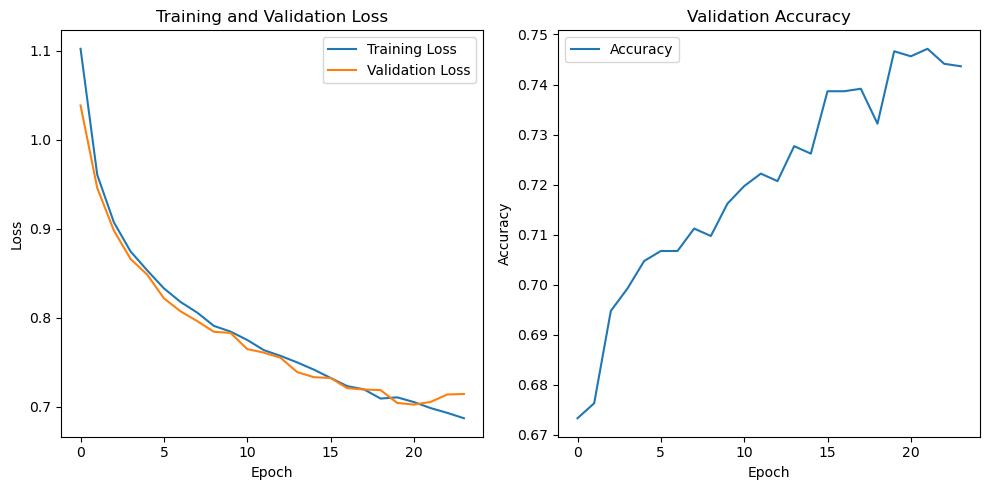

In [18]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Calculate the flattened size
        # The input shape (3, 64, 64) corresponds to the RGB channels (3) and image dimensions (64x64), matching the DermaMNIST dataset.
        self.flattened_size = self.get_flattened_size((3, 64, 64))
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 7)

    def get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        # Ensure that the target is in the correct format (class indices) for compatibility with CrossEntropyLoss.
        data, target = data.to(device), target.to(device)
        target = target.long()  # Ensure target is of type torch.long
        if len(target.size()) > 1:
                target = target.squeeze()  # Remove extra dimensions

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.long()  # Ensure target is of type torch.long
            if len(target.size()) > 1:
                target = target.squeeze()  # Remove extra dimensions
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Set your desired seed value here
    
# Hyperparameters and device setup
batch_size = 64
epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data preparation
train_dataset = DermaMNIST(root='./data', split="train", download=True, transform=transform_train, size=64)
test_dataset = DermaMNIST(root='./data', split="test", download=True, transform=transform_test, size=64)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training and testing loop
train_losses = []
test_losses = []
accuracies = []
patience = 3  # Number of epochs to wait for improvement
best_test_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    # Check for improvement
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    # Early stopping condition
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plotting the training progress
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()